In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [77]:
from wordcloud import WordCloud

In [16]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=e78d72bbb92cfadcc6f4e60e3b0fcf70353b72bfb0034aa8e8554cc478f86592
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwvnbyt9/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [17]:
import en_core_web_lg

In [2]:
!pip install keybert

     |████████████████████████████████| 78 kB 4.1 MB/s 
     |████████████████████████████████| 214 kB 15.5 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
     |████████████████████████████████| 3.1 MB 42.0 MB/s 
     |████████████████████████████████| 3.3 MB 45.8 MB/s 
     |████████████████████████████████| 1.2 MB 49.0 MB/s 
     |████████████████████████████████| 61 kB 529 kB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
     |████████████████████████████████| 895 kB 77.1 MB/s 
  Created wheel for keybert: filename=keybert-0.5.0-py3-none-any.whl size=20491 sha256=d0b5101a35018db0c7c6849cb4c4c747cf242eb12011b4b5542bd4865d473b57
  Stored in directory: /root/.cache/pip/wheels/99/1f/3f/590d2997adbb2d0e1f82e8ee05d42d6910e92c3ed283015ff8
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=7161508b7a91109ff5ecdaed74289a2bac943dcbb19ed909406df6a748a4dddb
  Stored in directory: /root/.cache/pip/whee

In [3]:
from keybert import KeyBERT

In [18]:
nlp = en_core_web_lg.load()

In this notebook, we are going to extract, analyze and compare the keywords from the complaint reports filed by civilian and police under the scenario where the officers have been disciplined

In [4]:
df_disciplined = pd.read_csv("/content/drive/MyDrive/DSS_CP5/data_cp5_disciplined.csv")
df_disciplined.head()

,crid,incident_year,is_officer_complaint,cr_text,category,allegation_name,text_content,complaint_narrative,officer_id,disciplined,gender,race,rank,current_salary,allegation_count,discipline_count,honorable_mention_count,major_award_count,civilian_compliment_count
0,1061320,2007,True,NaN,Conduct Unbecoming (Off-Duty),Indebtedness To City,AUTO CR - LOG SUMMARY #1061320\n\nTYPE: CR\n\n...,for,12007,True,M,Hispanic,Police Officer,93354.0,33,3,16,0,3
1,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,It is reported that the accused officers were\...,25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1
2,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,SUSTAINED,25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1
3,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,It is reported that the accused officers were\...,25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1
4,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,"The reporting party, Sgt. William KAPPEL, star...",25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1


In [5]:
df_disciplined.shape

(1501, 19)

In [6]:
df_disciplined["crid"].nunique()

392

In [7]:
df_disciplined_fil = df_disciplined.drop_duplicates(subset=['crid'])
df_disciplined_fil.shape

(392, 19)

let's start our analysis with civilian complaints

In [8]:
df_civ_complaints = df_disciplined_fil[df_disciplined_fil['is_officer_complaint'] == False]
df_civ_complaints.shape

(47, 19)

Let us look at some of the type of complaint categories and allegation names, this will help us later in understanding how similar the keyword extraction results are with respect to the actual categories and allegation names

In [9]:
df_civ_complaints["category"].value_counts()

Operation/Personnel Violations    25
Lockup Procedures                  5
Conduct Unbecoming (Off-Duty)      4
Illegal Search                     3
Use Of Force                       3
Traffic                            2
Criminal Misconduct                2
Supervisory Responsibilities       1
Domestic                           1
Drug / Alcohol Abuse               1
Name: category, dtype: int64

In [10]:
df_civ_complaints["allegation_name"].value_counts()

Inadequate / Failure To Provide Service               17
Prisoners Property                                     4
Miscellaneous                                          4
Improper Search Of Vehicle                             3
Neglect Of Duty                                        2
Association With Felon                                 2
Slow / No Response                                     2
Leaving Assignment (District, Beat, Sector, Court)     1
Altercation / Disturbance - Neighbor                   1
Indebtedness To City                                   1
Excessive Force / On Duty - No Injury                  1
Fail To Obtain A Complaint Register Number             1
Improper Processing / Reporting / Procedures           1
Domestic Altercation - Physical Abuse                  1
Reports                                                1
Intoxicated Off Duty                                   1
Arrest, Improper Procedures                            1
Damage / Trespassing To Propert

In [11]:
complaint_narrative_civ = df_civ_complaints["complaint_narrative"].tolist()

In [22]:
def create_complaint_corpus(complaint_list, custom_lemmas=[]):
    
    corpus = []
    words_dict = {}
    
    for cur_complaint in complaint_list:

      cur_complaint_tokens = []  
      doc = nlp(cur_complaint.lower())

      for token in doc:
        
        if token.lemma_ != '-PRON-' and len(token.lemma_) > 1 and not token.is_space and not token.is_stop and not token.is_punct and not token.like_num and not token.ent_type:

          if token.lemma_ not in custom_lemmas:
            
            cur_complaint_tokens.append(token.lemma_)
            words_dict[token.lemma_] = words_dict.get(token.lemma_, 0) + 1
            
      if len(cur_complaint_tokens) > 0:
        corpus.append(cur_complaint_tokens)
                
                
    return (corpus, words_dict)

In [39]:
def plot_word_count_bar_chart(word_dict, num_of_words, type_of_report, x_label='Word', y_label='Count'):
  #convert the word dict to list of items and then sort it by count and showcase the top n words with most frequency
  word_count_list = sorted(list(word_dict.items()), reverse=True, key=lambda word: word[1])[0:num_of_words]
  word_count_df = pd.DataFrame(word_count_list, columns=[x_label, y_label])
  ax = sns.barplot(x=x_label, y=y_label, data=word_count_df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
  #just a note, in our usecase, the words are typically lemmatized during the text cleaning process
  ax.set_title('Most frequent words in the ' + type_of_report + ' complaint reports')
  plt.show()

In [94]:
def generate_word_cloud(input_dict, type_of_report, width=800, height=800, background_color="white", max_words=50):

  wc = WordCloud(width=width, height=height, background_color=background_color, max_words=max_words).generate_from_frequencies(input_dict)
  plt.figure(figsize=(24,12))
  plt.imshow(wc)
  plt.axis("off")
  plt.title('Word cloud of keywords in the ' + type_of_report + ' complaint reports')
  plt.show()

In [20]:
custom_stop_words = ["accuse", "report", "officer", "allege", "city", "chicago", "police", "party", "complainant", "victim", "provide", "complaint"]

In [23]:
corpus_civ, words_dict_civ = create_complaint_corpus(complaint_narrative_civ, custom_stop_words)

In [24]:
len(corpus_civ)

47

In [41]:
sns.set(font_scale=1.5)
pylab.rcParams['figure.figsize'] = 18, 6

In [58]:
#plot_word_count_bar_chart(words_dict_civ, num_of_words=30, type_of_report='civilian-disciplined')

Now that we have cleaned the corpus, let us convert it into a format that can be used by the KeyBert Model

In [29]:
corpus_civ_for_kbert = [" ".join(cur_list_tokens) for cur_list_tokens in corpus_civ]

In [33]:
corpus_civ[3]

['fail',
 'properly',
 'investigate',
 'traffic',
 'accident',
 'vehicle',
 'vehicle',
 'strike',
 'female',
 'issue',
 'citation',
 'test',
 'alcohol',
 'give',
 'driver',
 'copy',
 'traffic',
 'crash',
 'try',
 'piece',
 'paper',
 'number',
 'write',
 'reluctantly',
 'complete',
 'additional',
 'unit',
 'fail',
 'proper',
 'information',
 'involved',
 'falsely',
 'check',
 'statement',
 'take']

In [34]:
corpus_civ_for_kbert[3]

'fail properly investigate traffic accident vehicle vehicle strike female issue citation test alcohol give driver copy traffic crash try piece paper number write reluctantly complete additional unit fail proper information involved falsely check statement take'

In [36]:
kw_model_civ = KeyBERT()

In [37]:
keywords_civ1 = kw_model_civ.extract_keywords(corpus_civ_for_kbert, keyphrase_ngram_range=(1, 1), stop_words='english')

47it [00:00, 809.69it/s]


In [44]:
keywords_civ1[0]

[('fail', 0.3441),
 ('return', 0.4309),
 ('purse', 0.4935),
 ('inventory', 0.4956)]

In [45]:
keywords_civ1_dict = {}
for cur_keyword_grp in keywords_civ1:
  for cur_keyword in cur_keyword_grp:
    if cur_keyword[0] not in keywords_civ1_dict:
      keywords_civ1_dict[cur_keyword[0]] = []
    keywords_civ1_dict[cur_keyword[0]].append(cur_keyword[1])

In [46]:
keywords_civ1_dict

{'accident': [0.3865, 0.3028, 0.4126],
 'accidentally': [0.3576],
 'action': [0.3273],
 'altercation': [0.5814],
 'ambulance': [0.3392],
 'apartment': [0.3235],
 'arrest': [0.4848, 0.4337, 0.3553, 0.3796, 0.6135, 0.5264, 0.5311],
 'battery': [0.444, 0.7288],
 'bike': [0.3103],
 'bitch': [0.2993],
 'body': [0.2658],
 'braclett': [0.306],
 'brag': [0.4118],
 'burglarize': [0.4735],
 'burglary': [0.5623],
 'buttock': [0.311],
 'car': [0.2653, 0.3325, 0.2636],
 'case': [0.275, 0.7704],
 'casino': [0.4046],
 'citation': [0.4085],
 'clothing': [0.3561],
 'complete': [0.2157, 0.231],
 'conflict': [0.3405],
 'court': [0.417],
 'crash': [0.349],
 'credential': [0.4864],
 'criminal': [0.333],
 'damage': [1.0],
 'deceased': [0.3857],
 'department': [0.3677, 0.3918, 0.3243],
 'deport': [0.3608],
 'desk': [0.471],
 'discharge': [0.3867],
 'dispute': [0.3257],
 'domestic': [0.5485],
 'door': [0.4326],
 'driver': [0.396],
 'engage': [0.3787],
 'enter': [1.0],
 'escalate': [0.3393],
 'fail': [0.3441,


In [53]:
sorted(keywords_civ1_dict.items(), key= lambda x:len(x[1]), reverse=True)[0:24]

[('fail',
  [0.3441,
   0.4529,
   0.4064,
   0.4288,
   0.3812,
   0.3279,
   0.3166,
   0.3101,
   0.3956,
   0.2715]),
 ('state', [0.3552, 0.3043, 0.3265, 0.3279, 0.9678, 0.3252, 0.4247, 0.3847]),
 ('arrest', [0.4848, 0.4337, 0.3553, 0.3796, 0.6135, 0.5264, 0.5311]),
 ('refuse', [0.4065, 0.3635, 0.4017, 0.2698, 0.2865]),
 ('witness', [0.5676, 0.3085, 0.3404, 0.3495]),
 ('rude', [0.3138, 0.2888, 0.3303]),
 ('unprofessional', [0.343, 0.3266, 0.3461]),
 ('strike', [0.3052, 0.3468, 0.3071]),
 ('accident', [0.3865, 0.3028, 0.4126]),
 ('protection', [0.3283, 0.3598, 0.3296]),
 ('car', [0.2653, 0.3325, 0.2636]),
 ('department', [0.3677, 0.3918, 0.3243]),
 ('vehicle', [0.3404, 0.6674, 0.2677]),
 ('return', [0.4309, 0.3697]),
 ('inventory', [0.4956, 0.4313]),
 ('warrant', [0.3879, 0.4289]),
 ('case', [0.275, 0.7704]),
 ('battery', [0.444, 0.7288]),
 ('offender', [0.3509, 0.3536]),
 ('steal', [0.3135, 0.4419]),
 ('incident', [0.3179, 0.4012]),
 ('hang', [0.3265, 0.2947]),
 ('wife', [0.2634, 0

In [56]:
def plot_keyword_count_bar_chart(word_dict, num_of_words, type_of_report, x_label='Keyword', y_label='Count'):
  #convert the word dict to list of items and then sort it by count and showcase the top n keywords with most frequency
  word_count_dict = {}
  for word in word_dict:
    word_count_dict[word] = len(word_dict[word])

  word_count_list = sorted(list(word_count_dict.items()), reverse=True, key=lambda word: word[1])[0:num_of_words]
  word_count_df = pd.DataFrame(word_count_list, columns=[x_label, y_label])
  ax = sns.barplot(x=x_label, y=y_label, data=word_count_df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
  #just a note, in our usecase, the keywords are typically lemmatized during the text cleaning process
  ax.set_title('Most frequent keywords in the ' + type_of_report + ' complaint reports')
  plt.show()

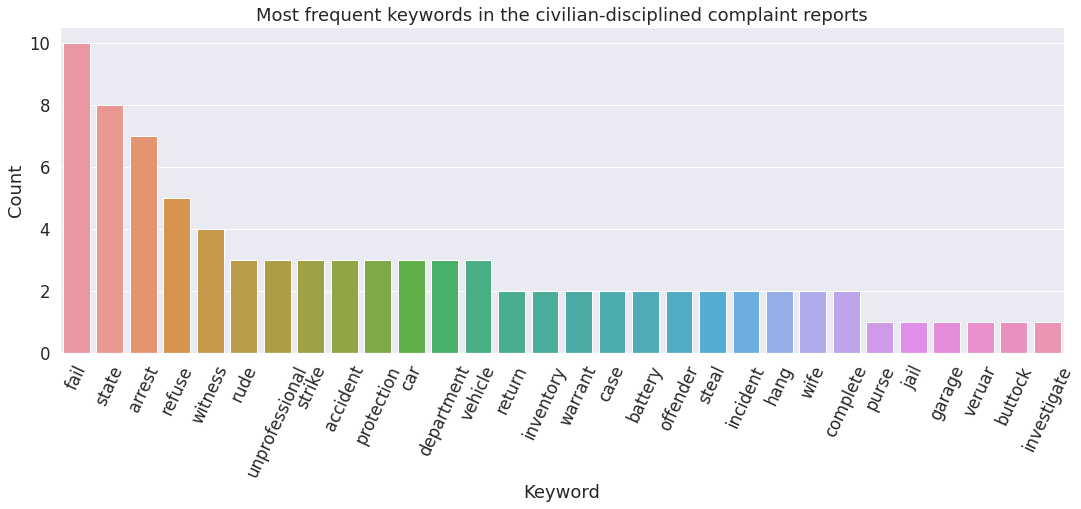

In [57]:
plot_keyword_count_bar_chart(keywords_civ1_dict, num_of_words=30, type_of_report='civilian-disciplined')

In [86]:
keyword_count_dict_civ = {}
for word in keywords_civ1_dict:
  keyword_count_dict_civ[word] = len(keywords_civ1_dict[word])

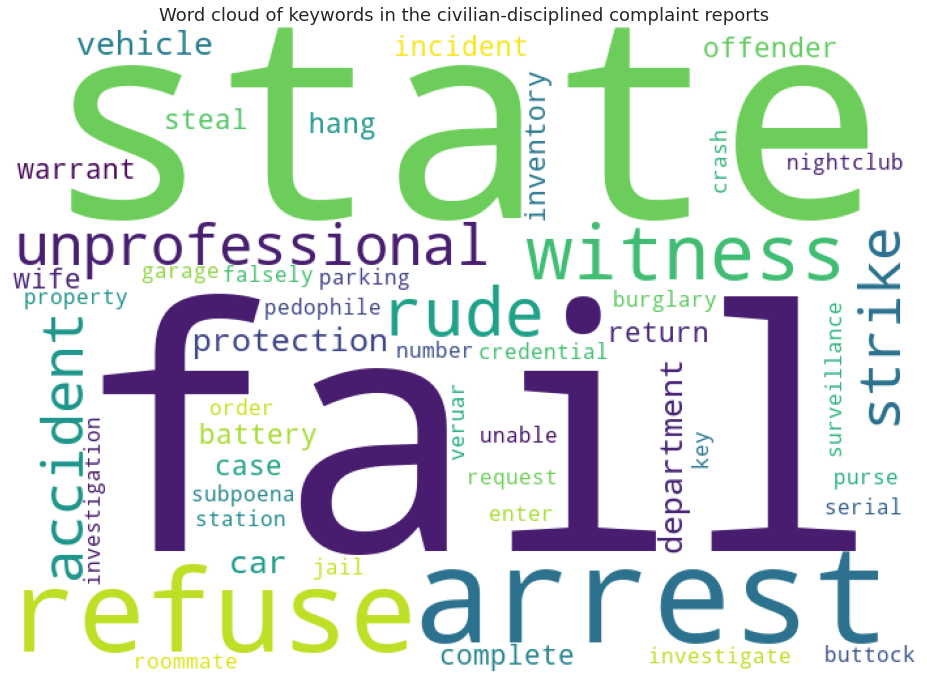

In [97]:
generate_word_cloud(keyword_count_dict_civ, 'civilian-disciplined', width=700, height=500)

In [100]:
#keywords_civ2 = kw_model_civ.extract_keywords(corpus_civ_for_kbert, keyphrase_ngram_range=(1, 2), stop_words='english')

In [101]:
#keywords_civ2

Let us now analyze the complaint reports which was filed by the police and the officers were disciplined


In [59]:
df_pol_complaints = df_disciplined_fil[df_disciplined_fil['is_officer_complaint'] == True]
df_pol_complaints.shape

(345, 19)

Let us look at some of the type of complaint categories and allegation names, this will help us later in understanding how similar the topic modeling results are with respect to the actual categories and allegation names

In [60]:
df_pol_complaints['category'].value_counts()

Operation/Personnel Violations    209
Conduct Unbecoming (Off-Duty)      87
Lockup Procedures                  24
Drug / Alcohol Abuse               11
Criminal Misconduct                 5
Bribery / Official Corruption       3
Use Of Force                        2
Illegal Search                      1
Supervisory Responsibilities        1
Traffic                             1
False Arrest                        1
Name: category, dtype: int64

In [61]:
df_pol_complaints['allegation_name'].value_counts()[0:25]

Neglect Of Duty                                            77
Indebtedness To City                                       70
Miscellaneous                                              29
Weapon / Ammunition                                        23
Insubordination                                            22
Misuse Of Department Equipment / Supplies                  15
Escape                                                     13
Association With Felon                                     13
Inventory Procedures                                       10
Leaving Assignment (District, Beat, Sector, Court)          9
Seat Belts                                                  9
Prisoners Property                                          4
Absent Without Permission                                   4
Search - Person / Property                                  4
Intoxicated On Duty                                         4
D.U.I. - Off Duty                                           3
Court At

In [62]:
complaint_narrative_pol = df_pol_complaints["complaint_narrative"].tolist()

In [63]:
corpus_pol, words_dict_pol = create_complaint_corpus(complaint_narrative_pol, custom_stop_words)

In [64]:
len(corpus_pol)

330

In [102]:
#plot_word_count_bar_chart(words_dict_pol, num_of_words=30, type_of_report='police-disciplined')

Now that we have cleaned the corpus, let us convert it into a format that can be used by the KeyBert Model

In [66]:
corpus_pol_for_kbert = [" ".join(cur_list_tokens) for cur_list_tokens in corpus_pol]

In [69]:
corpus_pol[3]

['sign', 'radio', 'leave', 'partner', 'date', 'able', 'locate', 'radio']

In [68]:
corpus_pol_for_kbert[3]

'sign radio leave partner date able locate radio'

In [70]:
kw_model_pol = KeyBERT()

In [71]:
keywords_pol1 = kw_model_pol.extract_keywords(corpus_pol_for_kbert, keyphrase_ngram_range=(1, 1), stop_words='english')

330it [00:00, 821.94it/s]


In [72]:
keywords_pol1_dict = {}
for cur_keyword_grp in keywords_pol1:
  for cur_keyword in cur_keyword_grp:
    if cur_keyword[0] not in keywords_pol1_dict:
      keywords_pol1_dict[cur_keyword[0]] = []
    keywords_pol1_dict[cur_keyword[0]].append(cur_keyword[1])

In [75]:
sorted(keywords_pol1_dict.items(), key= lambda x:len(x[1]), reverse=True)[0:5]

[('fail',
  [0.5301,
   0.3925,
   0.3012,
   0.3544,
   0.4594,
   0.346,
   0.3267,
   0.3074,
   0.2556,
   0.2209,
   0.3369,
   0.3677,
   0.2714,
   0.315,
   0.3622,
   0.3108,
   0.3693,
   0.2743,
   0.4137,
   0.4645,
   0.3301,
   0.7085,
   0.3821,
   0.2958,
   0.2592,
   0.3438,
   0.3923,
   0.5709,
   0.3075,
   0.3112,
   0.2952,
   0.31,
   0.4441,
   0.5326,
   0.7888,
   0.3572,
   0.3083,
   0.3161,
   0.3087,
   0.3338,
   0.325,
   0.325,
   0.325,
   0.3703,
   0.325,
   0.3403,
   0.3346,
   0.2701,
   0.2701,
   0.2701,
   0.3132,
   0.325,
   0.325,
   0.2718,
   0.2796,
   0.293,
   0.4014,
   0.3603,
   0.3768,
   0.4178,
   0.4612,
   0.3764,
   0.2649,
   0.2457,
   0.2388,
   0.3717,
   0.4045]),
 ('indebtedness',
  [0.5294,
   0.7884,
   1.0,
   0.7884,
   0.7884,
   0.7884,
   0.8048,
   0.7884,
   0.7884,
   1.0,
   0.884,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.6312,
   0.7417,
   0.4183,
   0.4183

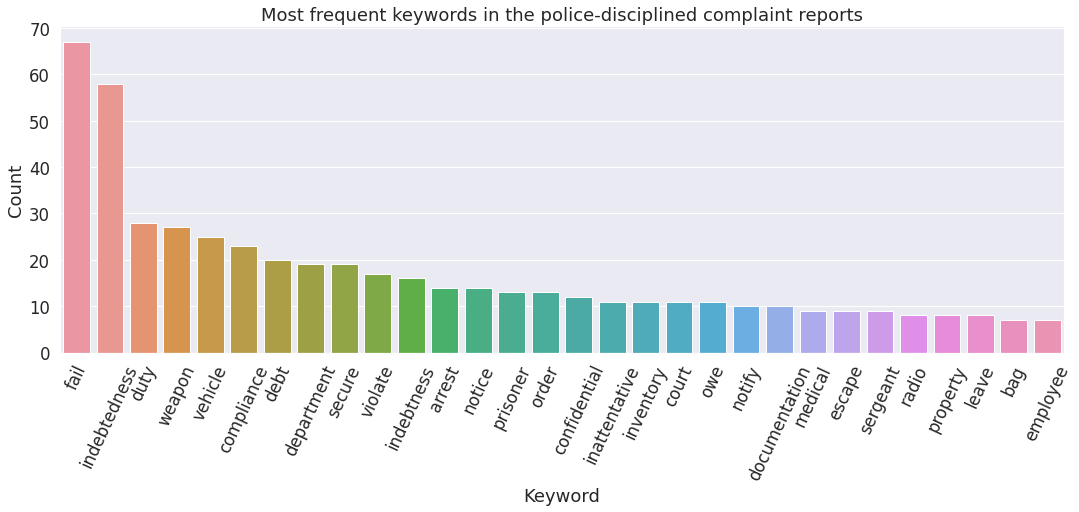

In [76]:
plot_keyword_count_bar_chart(keywords_pol1_dict, num_of_words=30, type_of_report='police-disciplined')

In [98]:
keyword_count_dict_pol = {}
for word in keywords_pol1_dict:
  keyword_count_dict_pol[word] = len(keywords_pol1_dict[word])

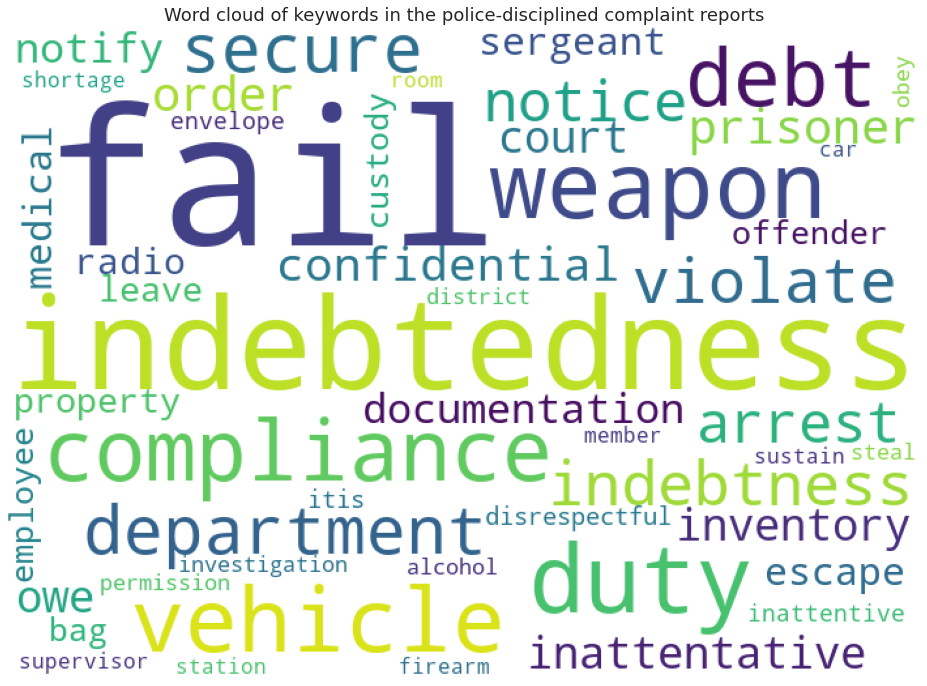

In [99]:
generate_word_cloud(keyword_count_dict_pol, 'police-disciplined', width=700, height=500)